# Open Set Classification

In [216]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms, models

In [217]:
device = torch.device("cuda")  # I am using GPU for faster progress.

## Data Preprocessing

### Transformations

In [218]:
## Load the dataset using PyTorch's data loading utilities
## Apply necessary preprocessing such as resizing and normalization

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing images to a uniform size.
    transforms.ToTensor(),         # Converting images to PyTorch tensors.
    transforms.Normalize(mean=[0.5,0.5,0.5],  std=[0.5,0.5,0.5])  # Normalizing pixel values.
])

# Load datasets
train_dataset = datasets.ImageFolder('C:/Users/Furkanpc/PythonWorkplace/Staj/Esen/MangoLeafBD Dataset/Known_Open45', transform=transform)
test_dataset = datasets.ImageFolder('C:/Users/Furkanpc/PythonWorkplace/Staj/Esen/MangoLeafBD Dataset/Real_World_Open45', transform=transform)

### Dataset Creating

In [219]:
# Splitting the data into training and testing sets while ensuring balanced classes.
train_class_names = train_dataset.classes
test_class_names = test_dataset.classes

train_class_indices = {class_name: [] for class_name in train_class_names}
for idx, (_, label) in enumerate(train_dataset.samples):
    train_class_indices[train_class_names[label]].append(idx)

test_class_indices = {class_name: [] for class_name in test_class_names}
for idx, (_, label) in enumerate(test_dataset.samples):
    test_class_indices[test_class_names[label]].append(idx)

# Shuffling the indices for each class.
for class_name in train_class_names:
    np.random.shuffle(train_class_indices[class_name])

for class_name in test_class_names:
    np.random.shuffle(test_class_indices[class_name])

# Initializing lists to store indices for train and test sets.
train_indices = []
val_indices = []
test_indices = []

# Splitting the data into training, and testing sets while maintaining class balance.
for class_name in train_class_names:
    train_indices.extend(train_class_indices[class_name][:300])
    val_indices.extend(train_class_indices[class_name][300:400])

for class_name in test_class_names:
    test_indices.extend(test_class_indices[class_name][400:500])

C:\Users\Furkanpc\AppData\Local\Temp\ipykernel_13584\1945909743.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(train_class_names, rotation=45, ha='right')
C:\Users\Furkanpc\AppData\Local\Temp\ipykernel_13584\1945909743.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(train_class_names, rotation=45, ha='right')
C:\Users\Furkanpc\AppData\Local\Temp\ipykernel_13584\1945909743.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(test_class_names, rotation=45, ha='right')


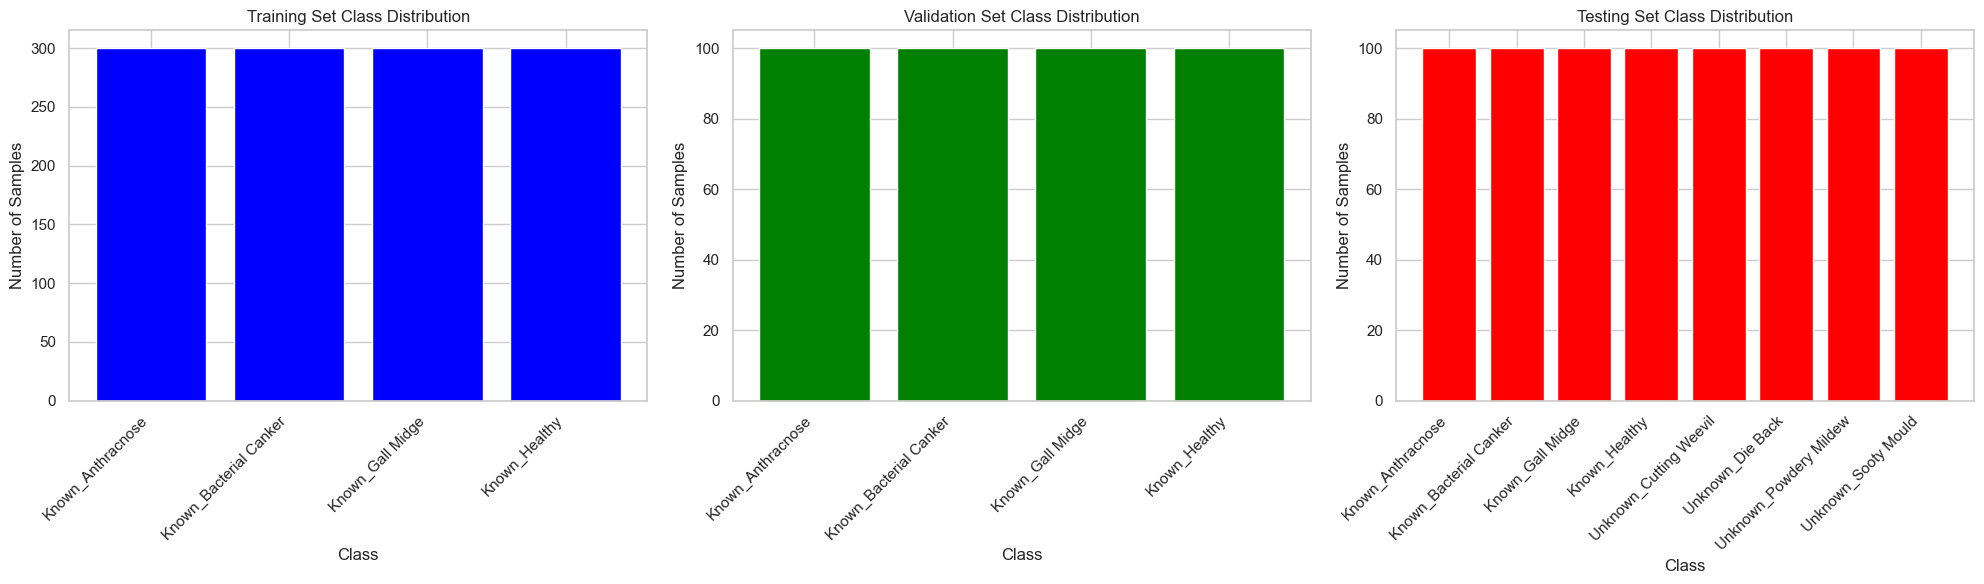

In [220]:
# Counting the number of samples per class in each dataset
train_class_counts = {class_name: 0 for class_name in train_class_names}
val_class_counts = {class_name: 0 for class_name in train_class_names}
test_class_counts = {class_name: 0 for class_name in test_class_names}

for idx in train_indices:
    class_name = train_class_names[train_dataset.targets[idx]]
    train_class_counts[class_name] += 1

for idx in val_indices:
    class_name = train_class_names[train_dataset.targets[idx]]
    val_class_counts[class_name] += 1

for idx in test_indices:
    class_name = test_class_names[test_dataset.targets[idx]]
    test_class_counts[class_name] += 1

# Plotting the class distribution
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Training set distribution
axs[0].bar(train_class_counts.keys(), train_class_counts.values(), color='blue')
axs[0].set_title('Training Set Class Distribution')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Number of Samples')
axs[0].set_xticklabels(train_class_names, rotation=45, ha='right')

# Validation set distribution
axs[1].bar(val_class_counts.keys(), val_class_counts.values(), color='green')
axs[1].set_title('Validation Set Class Distribution')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Number of Samples')
axs[1].set_xticklabels(train_class_names, rotation=45, ha='right')

# Testing set distribution
axs[2].bar(test_class_counts.keys(), test_class_counts.values(), color='red')
axs[2].set_title('Testing Set Class Distribution')
axs[2].set_xlabel('Class')
axs[2].set_ylabel('Number of Samples')
axs[2].set_xticklabels(test_class_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()

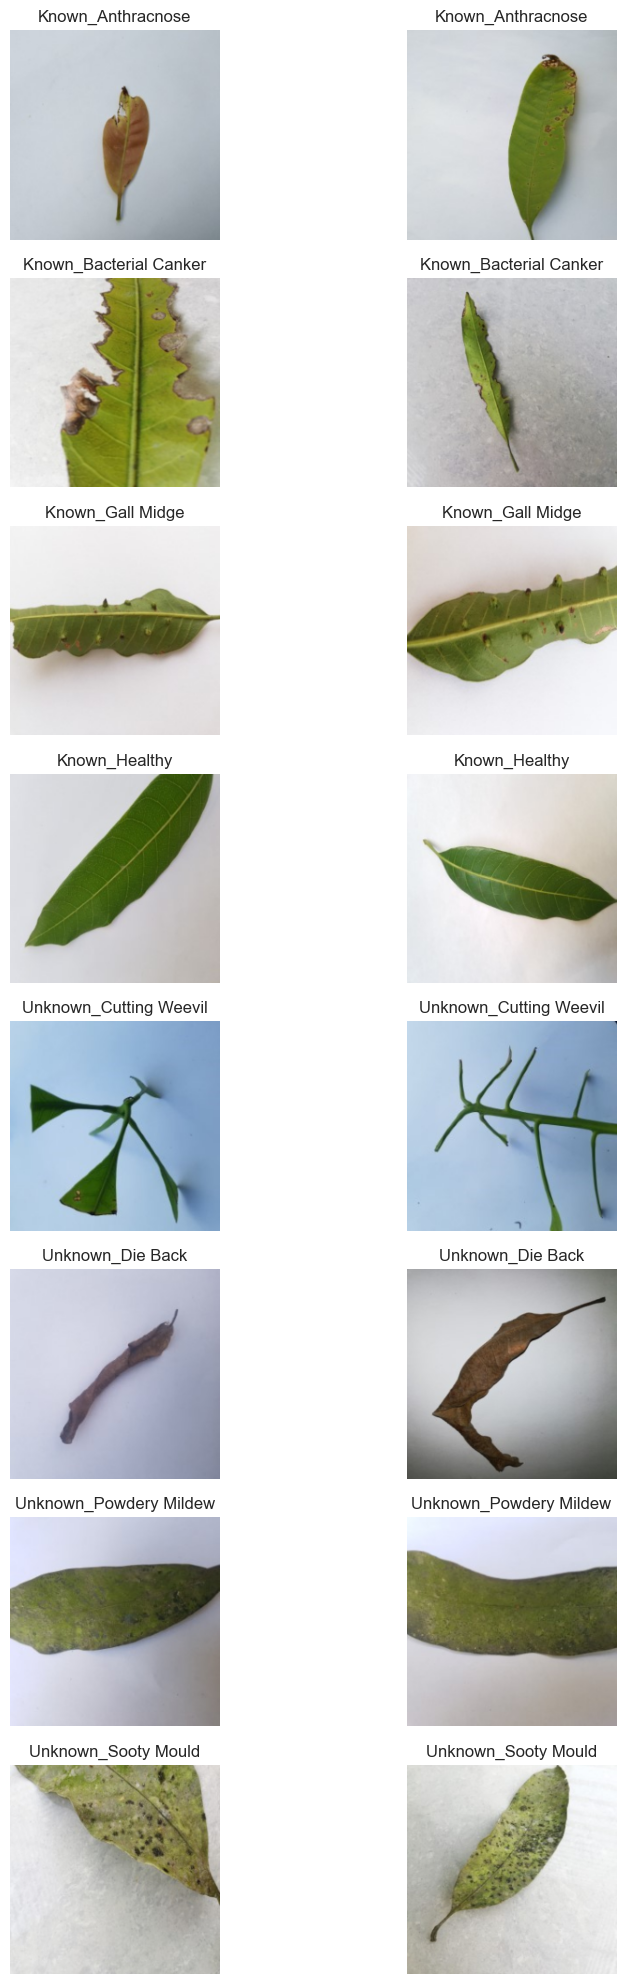

In [221]:
# Collect indices of two examples per class
for idx, (_, label) in enumerate(test_dataset.samples):
    if len(test_class_indices[test_class_names[label]]) < 2:
        test_class_indices[test_class_names[label]].append(idx)

# Display two sample images for each class
fig, axes = plt.subplots(len(test_class_names), 2, figsize=(10, len(test_class_names) * 2.5))

for i, class_name in enumerate(test_class_names):
    for j in range(2):
        idx = test_class_indices[class_name][j]
        image, label = test_dataset[idx]
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        ax = axes[i, j]
        ax.imshow(image)
        ax.set_title(f'{class_name}')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [222]:
# Defining samplers for obtaining training, and test sets.
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Defining data loaders.
train_loader = DataLoader(train_dataset,batch_size=32,sampler=train_sampler)
val_loader = DataLoader(train_dataset,batch_size=32,sampler=val_sampler)
test_loader = DataLoader(test_dataset,batch_size=32,sampler=test_sampler)

# Mapping of classes to integers for train dataset
print("Train Dataset Class to Index Mapping:")
print(train_dataset.class_to_idx)
# Mapping of classes to integers for test dataset
print("Test Dataset Class to Index Mapping:")
print(test_dataset.class_to_idx)

# Printing the sizes of train, validation, and test sets.
print(f"Number of training samples: {len(train_indices)}")
print(f"Number of validation samples: {len(val_indices)}")
print(f"Number of test samples: {len(test_indices)}")

Train Dataset Class to Index Mapping:
{'Known_Anthracnose': 0, 'Known_Bacterial Canker': 1, 'Known_Gall Midge': 2, 'Known_Healthy': 3}
Test Dataset Class to Index Mapping:
{'Known_Anthracnose': 0, 'Known_Bacterial Canker': 1, 'Known_Gall Midge': 2, 'Known_Healthy': 3, 'Unknown_Cutting Weevil': 4, 'Unknown_Die Back': 5, 'Unknown_Powdery Mildew': 6, 'Unknown_Sooty Mould': 7}
Number of training samples: 1200
Number of validation samples: 400
Number of test samples: 800


## ResNet50 Feature Extractor

### Architecture

In [223]:
class ResNet50FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet50FeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=pretrained)
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Remove the final classification layer

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        return x

### Training

In [224]:
def train_resnet50(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.train()

    # Lists to store training and validation loss and accuracy values
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        epoch_train_corrects = 0
        epoch_train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            epoch_train_loss += loss.item() * images.size(0)

            # Calculate training accuracy
            _, preds = torch.max(outputs, 1)
            epoch_train_corrects += torch.sum(preds == labels.data)
            epoch_train_total += labels.size(0)

        # Calculate average training loss and accuracy
        epoch_train_loss = epoch_train_loss / len(train_loader.dataset)
        epoch_train_accuracy = epoch_train_corrects.double() / epoch_train_total

        # Store training loss and accuracy for plotting
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy.item())

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        epoch_val_corrects = 0
        epoch_val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Move data to GPU

                outputs = model(images)
                loss = criterion(outputs, labels)

                # Accumulate validation loss
                epoch_val_loss += loss.item() * images.size(0)

                # Calculate validation accuracy
                _, preds = torch.max(outputs, 1)
                epoch_val_corrects += torch.sum(preds == labels.data)
                epoch_val_total += labels.size(0)

        # Calculate average validation loss and accuracy
        epoch_val_loss = epoch_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = epoch_val_corrects.double() / epoch_val_total

        # Store validation loss and accuracy for plotting
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy.item())

        # Print epoch information
        print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {epoch_train_loss:.4f}  Train Accuracy: {epoch_train_accuracy:.4f}  Val Loss: {epoch_val_loss:.4f}  Val Accuracy: {epoch_val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [225]:
# Initialize the model, loss function, and optimizer
resnet_model = ResNet50FeatureExtractor(pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10

train_losses, train_accuracies, val_losses, val_accuracies = train_resnet50(
    resnet_model, train_loader, val_loader, criterion, optimizer, num_epochs, device=device)


C:\Users\Furkanpc\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Furkanpc\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10]  Train Loss: 4.0577  Train Accuracy: 0.1100  Val Loss: 1.1036  Val Accuracy: 0.3225
Epoch [2/10]  Train Loss: 3.2186  Train Accuracy: 0.5633  Val Loss: 0.9374  Val Accuracy: 0.7175
Epoch [3/10]  Train Loss: 2.4579  Train Accuracy: 0.8750  Val Loss: 0.7130  Val Accuracy: 0.8275
Epoch [4/10]  Train Loss: 1.7405  Train Accuracy: 0.9775  Val Loss: 0.5415  Val Accuracy: 0.9550
Epoch [5/10]  Train Loss: 1.1654  Train Accuracy: 0.9942  Val Loss: 0.2911  Val Accuracy: 0.9950
Epoch [6/10]  Train Loss: 0.7700  Train Accuracy: 0.9933  Val Loss: 0.1599  Val Accuracy: 1.0000
Epoch [7/10]  Train Loss: 0.4794  Train Accuracy: 0.9992  Val Loss: 0.0882  Val Accuracy: 1.0000
Epoch [8/10]  Train Loss: 0.3307  Train Accuracy: 1.0000  Val Loss: 0.1096  Val Accuracy: 1.0000
Epoch [9/10]  Train Loss: 0.2624  Train Accuracy: 0.9992  Val Loss: 0.1144  Val Accuracy: 0.9975
Epoch [10/10]  Train Loss: 0.1992  Train Accuracy: 1.0000  Val Loss: 0.0546  Val Accuracy: 1.0000


In [226]:
# Save the trained model
model_save_path = "resnet50_trained_model.pth"
torch.save(resnet_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to resnet50_trained_model.pth


In [227]:
"""# Load the trained model
resnet_model = ResNet50FeatureExtractor(pretrained=False).to(device)
resnet_model.load_state_dict(torch.load(model_save_path))
resnet_model.eval()  # Set the model to evaluation mode
print("Model loaded and ready for inference or further training.")"""

'# Load the trained model\nresnet_model = ResNet50FeatureExtractor(pretrained=False).to(device)\nresnet_model.load_state_dict(torch.load(model_save_path))\nresnet_model.eval()  # Set the model to evaluation mode\nprint("Model loaded and ready for inference or further training.")'

### Evaluation

In [228]:
# Function to plot training and validation loss and accuracy
def plot_training_validation_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plotting the loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

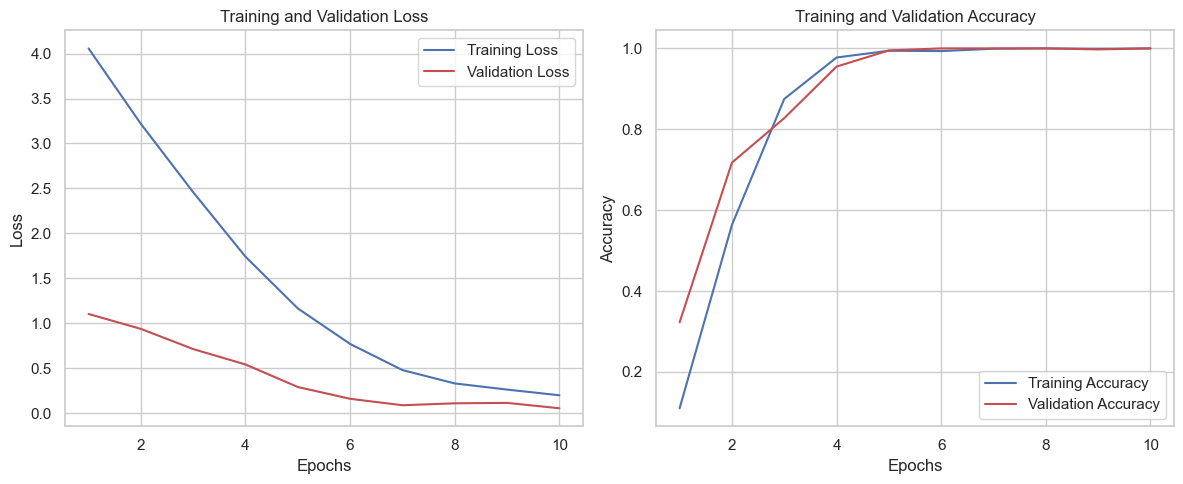

In [229]:
# Plotting the results
plot_training_validation_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

### Feature Extraction

In [230]:
# Function to extract features using the trained model
def extract_features(model, dataloader, device):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            feats = model(images)
            features.append(feats.cpu().numpy())
            labels.append(lbls.cpu().numpy())
    return np.vstack(features), np.hstack(labels)

In [231]:
# Özellikleri GPU'da çıkart
train_features, train_labels = extract_features(resnet_model, train_loader, device=device)
test_features, test_labels = extract_features(resnet_model, test_loader, device=device)

print("Shape of train_features:", train_features.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_features:", test_features.shape)
print("Shape of test_labels:", test_labels.shape)

Shape of train_features: (1200, 2048)
Shape of train_labels: (1200,)
Shape of test_features: (800, 2048)
Shape of test_labels: (800,)


### Feature Dimension Reduction

In [232]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Function for t-SNE and plotting
def plot_tsne_comparison(train_features, train_labels, test_features, test_labels, openness):
    # Combine the train and test features
    combined_features = np.concatenate([train_features, test_features])
    combined_labels = np.concatenate([train_labels, test_labels])
    data_type_labels = ['Known'] * len(train_labels) + ['Unknown'] * len(test_labels)
    
    # Create a TSNE reducer
    reducer = TSNE(n_components=2, random_state=42)
    
    # Fit and transform the combined features
    tsne_combined_features = reducer.fit_transform(combined_features)
    
    # Split tsne_combined_features back into train and test
    split_index = len(train_features)
    tsne_train_features = tsne_combined_features[:split_index]
    tsne_test_features = tsne_combined_features[split_index:]
    
    # Create DataFrames for plotting
    df_train = pd.DataFrame(tsne_train_features, columns=['Component 1', 'Component 2'])
    df_train['Label'] = train_labels
    df_train['Data Type'] = 'Known'
    
    df_test = pd.DataFrame(tsne_test_features, columns=['Component 1', 'Component 2'])
    df_test['Label'] = test_labels
    df_test['Data Type'] = 'Unknown'
    
    df_combined = pd.DataFrame(tsne_combined_features, columns=['Component 1', 'Component 2'])
    df_combined['Label'] = combined_labels
    df_combined['Data Type'] = data_type_labels
    
    # Plotting
    fig, axs = plt.subplots(3, 1, figsize=(8, 16))
    
    # Plot Train Features
    sns.scatterplot(x='Component 1', y='Component 2', hue='Label', palette="tab10", data=df_train, s=60, ax=axs[0])
    axs[0].set_title(f"t-SNE of Train Features (Openness: {int(openness)}%)")
    axs[0].set_xlabel('Component 1')
    axs[0].set_ylabel('Component 2')
    axs[0].legend(loc='best', title='Label')
    
    # Plot Test Features
    sns.scatterplot(x='Component 1', y='Component 2', hue='Label', palette="tab10", data=df_test, s=60, ax=axs[1])
    axs[1].set_title(f"t-SNE of Test Features (Openness: {int(openness)}%)")
    axs[1].set_xlabel('Component 1')
    axs[1].set_ylabel('Component 2')
    axs[1].legend(loc='best', title='Label')
    
    # Plot Combined Features
    sns.scatterplot(x='Component 1', y='Component 2', hue='Label', style='Data Type', palette="tab10", data=df_combined, s=40, ax=axs[2])
    axs[2].set_title(f"t-SNE of Combined Features (Openness: {int(openness)}%)")
    axs[2].set_xlabel('Component 1')
    axs[2].set_ylabel('Component 2')
    axs[2].legend(loc='best', title='Label')

    plt.tight_layout()
    plt.show()

    return tsne_train_features, tsne_test_features

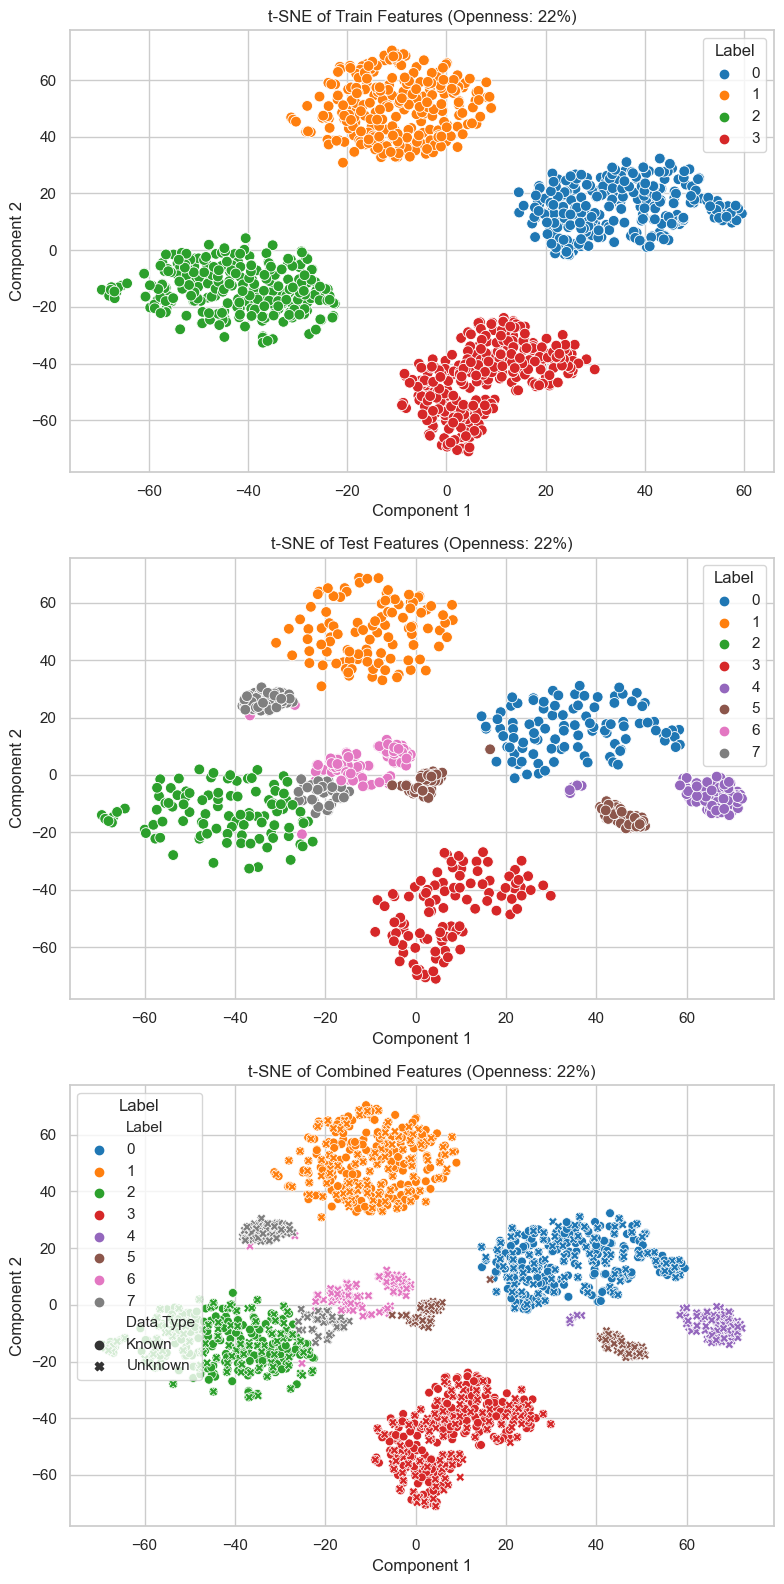

In [233]:
tsne_train_features, tsne_test_features = plot_tsne_comparison(train_features,train_labels,test_features,test_labels,22)

## Gaussian Mixture Model for OSC

### GMM Train

In [234]:
# Fit GMMs on the original high-dimensional features
gmms = {}
for class_label in np.unique(train_labels):
    class_features = tsne_train_features[train_labels == class_label]
    gmm = GaussianMixture(n_components=1, covariance_type='full')
    gmm.fit(class_features)
    gmms[class_label] = gmm

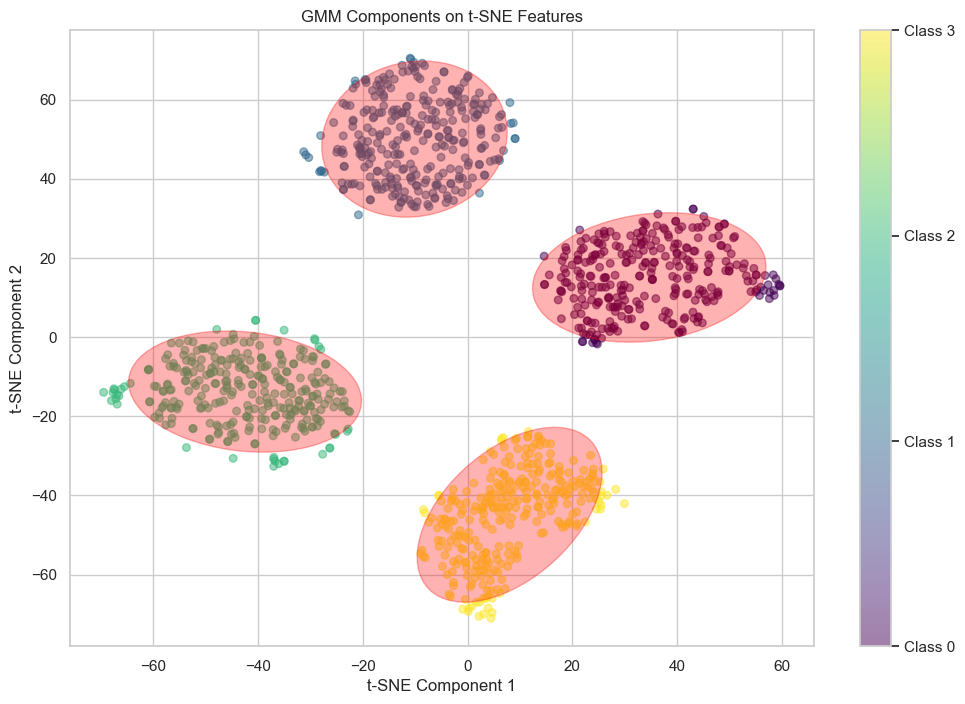

In [235]:
def plot_gmm_ellipses(tsne_features, labels, gmms, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))

    # Scatter plot of the t-SNE features
    scatter = ax.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='viridis', alpha=0.5, s=30)

    # Add a colorbar with class names
    cbar = plt.colorbar(scatter, ax=ax, ticks=np.arange(len(np.unique(labels))))
    cbar.ax.set_yticklabels([f'Class {i}' for i in np.unique(labels)])

    # Plot Gaussian ellipses for each GMM component
    for label, gmm in gmms.items():
        mean = gmm.means_[0]
        covar = gmm.covariances_[0]
        
        # Plot the covariance ellipse
        if covar.shape == (2, 2):
            plot_cov_ellipse(covar, mean, ax=ax, alpha=0.3, color='red')
        else:
            print(f"Covariance matrix is not 2x2 for class {label}. Unable to plot.")

    ax.set_title("GMM Components on t-SNE Features")
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    plt.show()

def plot_cov_ellipse(cov, pos, ax=None, nstd=2, **kwargs):
    """
    Plots an n-std ellipse based on the covariance matrix (cov) centered at the mean (pos).
    """
    if ax is None:
        ax = plt.gca()

    # Eigenvalue decomposition
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # Calculate width and height of the ellipse
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * nstd * np.sqrt(vals)

    # Create and add the ellipse
    ellipse = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ellipse)

# Call the plotting function
plot_gmm_ellipses(tsne_train_features, train_labels, gmms)

### Log Likelihood Threshold

In [236]:
# Calculate log-likelihoods for each class
log_likelihoods = {}
filtered_likelihoods = []

for label, gmm in gmms.items():
    class_features = tsne_train_features[train_labels == label]
    ll = gmm.score_samples(class_features)
    log_likelihoods[label] = ll
    
    # Calculate Q1 and Q3
    Q1 = np.percentile(ll, 25)
    Q3 = np.percentile(ll, 75)
    
    # Calculate IQR
    IQR = Q3 - Q1
    
    # Filter outliers
    non_outliers = ll[(ll >= Q1 - 1.5 * IQR) & (ll <= Q3 + 1.5 * IQR)]
    filtered_likelihoods.extend(non_outliers)

# Determine the likelihood threshold using filtered values
likelihood_threshold = min(filtered_likelihoods)

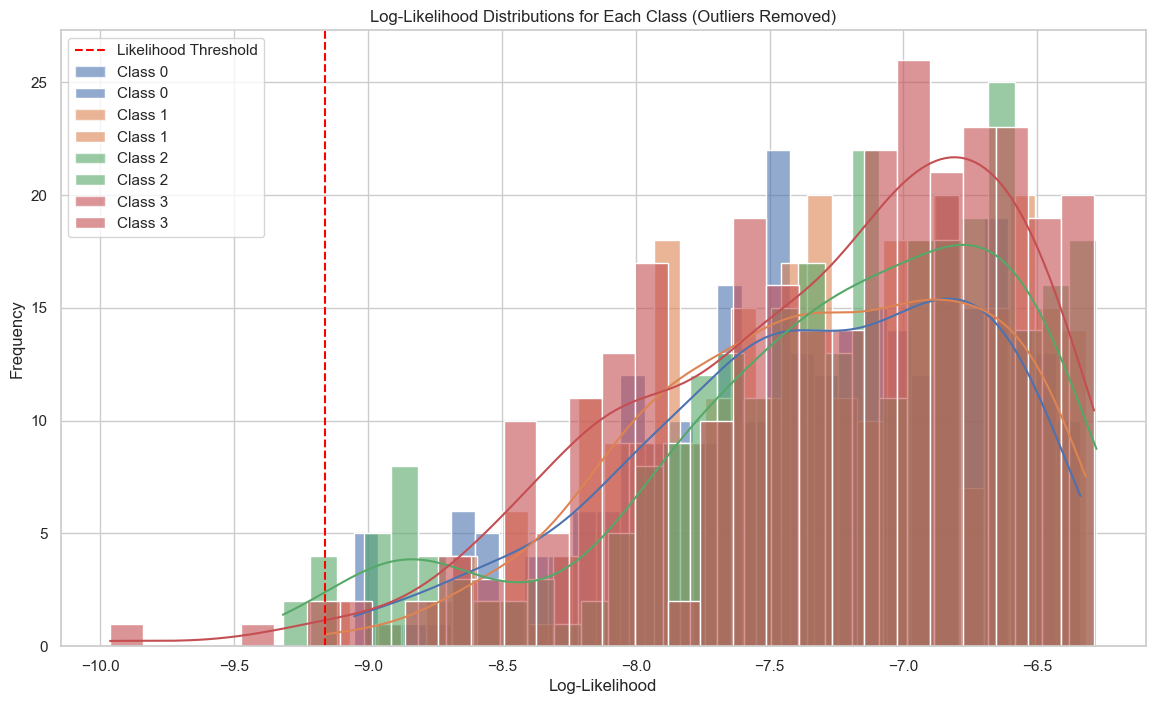

Likelihood Threshold (excluding outliers): -9.1617


In [237]:
# Plot the distributions of log-likelihoods
plt.figure(figsize=(14, 8))

for label, ll in log_likelihoods.items():
    sns.histplot(ll, bins=30, kde=True, label=f'Class {label}', alpha=0.6)

# Plot the threshold
plt.axvline(likelihood_threshold, color='red', linestyle='--', label='Likelihood Threshold')


plt.title('Log-Likelihood Distributions for Each Class (Outliers Removed)')
plt.xlabel('Log-Likelihood')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

print(f"Likelihood Threshold (excluding outliers): {likelihood_threshold:.4f}")

### Classification and Unknown Detection

In [238]:
def classify_and_detect(gmms,features, likelihood_threshold):
    with torch.no_grad():
        # Calculate likelihood for each GMM
        likelihoods = [gmm.score(features) for gmm in gmms.values()]
        
        # Determine if the image is an unknown class
        max_likelihood = max(likelihoods)
        if max_likelihood < likelihood_threshold:
            return -1  # Unknown class
        else:
            return np.argmax(likelihoods)

In [239]:
# Initialize variables to track true positives, etc.
tp_known = fp_known = fn_known = tn_known = 0
tp_unknown = fp_unknown = fn_unknown = tn_unknown = 0

# Process all test data
# Set the likelihood threshold to the minimum sample likelihood from the GMM
true_known_labels = []
predicted_known_labels = []
true_unknown_labels = []
predicted_unknown_labels = []

# Process each feature in tsne_test_features
for i in range(len(tsne_test_features)):
    feature = tsne_test_features[i].reshape(1, -1)  # Ensure feature is 2D for GMM
    true_label = test_labels[i]
    is_unknown = true_label in [4,5,6,7]  # Check if it's an unknown class
    true_label = -1 if is_unknown else true_label
    
    # Perform classification and detection
    result = classify_and_detect(gmms, feature, likelihood_threshold)
    
    if result == -1:
        if is_unknown:
            tp_unknown += 1  # Correctly identified as unknown
            tn_known += 1  # Correctly rejected as not a known class
            true_unknown_labels.append(true_label)
            predicted_unknown_labels.append(result)
        else:
            fp_unknown += 1  # Incorrectly identified as unknown
            fn_known += 1  # Incorrectly rejected as a known class
            true_known_labels.append(true_label)
            predicted_known_labels.append(result)
    else:
        if is_unknown:
            fn_unknown += 1  # Incorrectly identified as known
            fp_known += 1  # Incorrectly accepted as a known class
            true_unknown_labels.append(true_label)
            predicted_unknown_labels.append(result)
        else:
            tp_known += 1  # Correctly identified as known
            tn_unknown += 1  # Correctly rejected as not an unknown class
            true_known_labels.append(true_label)
            predicted_known_labels.append(result)

### Evaluation

In [240]:
report = classification_report(true_known_labels, predicted_known_labels)
print(report)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      0.96      0.98       100
           3       1.00      0.98      0.99       100

    accuracy                           0.98       400
   macro avg       0.80      0.79      0.79       400
weighted avg       1.00      0.98      0.99       400



C:\Users\Furkanpc\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Furkanpc\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Furkanpc\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [241]:
report = classification_report(true_known_labels + true_unknown_labels, predicted_known_labels + predicted_unknown_labels)
print(report)

              precision    recall  f1-score   support

          -1       0.98      0.94      0.96       400
           0       0.96      1.00      0.98       100
           1       1.00      1.00      1.00       100
           2       0.83      0.96      0.89       100
           3       1.00      0.98      0.99       100

    accuracy                           0.96       800
   macro avg       0.95      0.98      0.96       800
weighted avg       0.97      0.96      0.96       800



In [242]:
# Compute the confusion matrix
cm = confusion_matrix(true_known_labels + true_unknown_labels, predicted_known_labels + predicted_unknown_labels)
# Normalize the confusion matrix by row (i.e., by the number of true samples per class)
row_sums = cm.sum(axis=1, keepdims=True)
normalized_cm = cm / row_sums

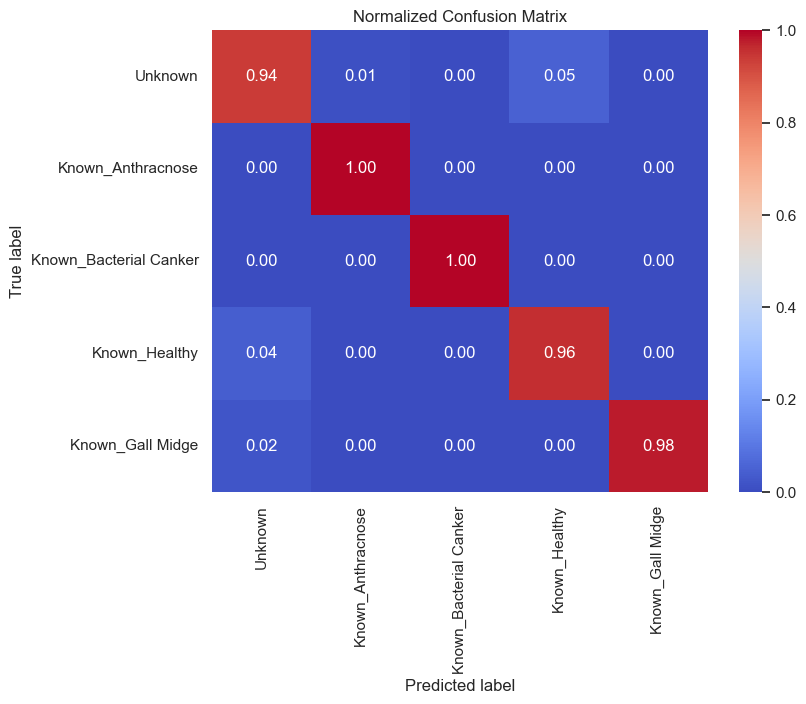

In [243]:
# Define the class names
class_names = ['Unknown', 'Known_Anthracnose','Known_Bacterial Canker', 'Known_Healthy', 'Known_Gall Midge']

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
                xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

# Call the plotting function with the normalized confusion matrix
plot_confusion_matrix(normalized_cm, class_names)